# Data Collecting and Preprocessing

In [28]:
import warnings
warnings.filterwarnings('ignore')


In [29]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd
import numpy as np
from pandasql import sqldf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import sqlite3

column_names = ['User_ID', 'Game', 'Action', 'Hours_Played', 'Useless Column']

df = pd.read_csv('steam-200k.csv', header=None, names=column_names)

df = df.drop('Useless Column', axis=1)
pysqldf = lambda q: sqldf(q, globals())

purchase_query = "SELECT User_ID, Game, Hours_Played as Purchase_Flag FROM df WHERE Action = 'purchase'"
play_query = "SELECT User_ID, Game, Hours_Played FROM df WHERE Action = 'play'"

purchases_df = pysqldf(purchase_query)
plays_df = pysqldf(play_query)

purchases_df = purchases_df.drop('Purchase_Flag', axis=1)

merged_df = pd.merge(purchases_df, plays_df, on=['User_ID', 'Game'], how='outer')

print(merged_df)

          User_ID                        Game  Hours_Played
0       151603712  The Elder Scrolls V Skyrim         273.0
1       151603712                   Fallout 4          87.0
2       151603712                       Spore          14.9
3       151603712           Fallout New Vegas          12.1
4       151603712               Left 4 Dead 2           8.9
...           ...                         ...           ...
129530  128470551                Fallen Earth           2.4
129531  128470551                 Magic Duels           2.2
129532  128470551                 Titan Souls           1.5
129533  128470551  Grand Theft Auto Vice City           1.5
129534  128470551                        RUSH           1.4

[129535 rows x 3 columns]


In [31]:
duplicate_rows = merged_df[merged_df.duplicated(keep=False)]
duplicate_counts = duplicate_rows.groupby(duplicate_rows.columns.tolist()).size().reset_index().rename(columns={0:'frequency'})
print(duplicate_counts)
merged_df.drop_duplicates(inplace=True)

       User_ID                                      Game  Hours_Played  \
0      1936551  Sid Meier's Civilization IV Colonization           7.4   
1      2259650               Sid Meier's Civilization IV           2.6   
2      2259650  Sid Meier's Civilization IV Colonization           0.2   
3      2259650      Sid Meier's Civilization IV Warlords           2.3   
4      4824107              Grand Theft Auto San Andreas           0.6   
..         ...                                       ...           ...   
291  205171017              Grand Theft Auto San Andreas          19.5   
292  241230534              Grand Theft Auto San Andreas           6.4   
293  243664576              Grand Theft Auto San Andreas           0.7   
294  267053376              Grand Theft Auto San Andreas          49.0   
295  302237901              Grand Theft Auto San Andreas           0.1   

     frequency  
0            2  
1            2  
2            2  
3            2  
4            2  
..       

In [32]:
duplicate_rows = merged_df[merged_df.duplicated(keep=False)]
duplicate_counts = duplicate_rows.groupby(duplicate_rows.columns.tolist()).size().reset_index().rename(columns={0:'frequency'})
print(duplicate_counts)

Empty DataFrame
Columns: [User_ID, Game, Hours_Played, frequency]
Index: []


In [33]:
missing_user_id = merged_df[merged_df['User_ID'].isnull()]
print(missing_user_id)

missing_game = merged_df[merged_df['Game'].isnull()]
print(missing_game)

missing_hours_played = merged_df[merged_df['Hours_Played'].isnull()]
print(missing_hours_played)

Empty DataFrame
Columns: [User_ID, Game, Hours_Played]
Index: []
Empty DataFrame
Columns: [User_ID, Game, Hours_Played]
Index: []
          User_ID                                          Game  Hours_Played
26      151603712                                     Alan Wake           NaN
27      151603712                                    BioShock 2           NaN
28      151603712                                  Fallen Earth           NaN
29      151603712             Fallout New Vegas Courier's Stash           NaN
30      151603712                  Fallout New Vegas Dead Money           NaN
...           ...                                           ...           ...
129506   99096740       The Elder Scrolls V Skyrim - Hearthfire           NaN
129511  176449171                                Counter-Strike           NaN
129512  176449171                 Counter-Strike Condition Zero           NaN
129513  176449171  Counter-Strike Condition Zero Deleted Scenes           NaN
129514  1764

In [34]:
merged_df['Hours_Played'].fillna(0, inplace=True)


In [35]:
missing_user_id = merged_df[merged_df['User_ID'].isnull()]
print(missing_user_id)

missing_game = merged_df[merged_df['Game'].isnull()]
print(missing_game)

missing_hours_played = merged_df[merged_df['Hours_Played'].isnull()]
print(missing_hours_played)

Empty DataFrame
Columns: [User_ID, Game, Hours_Played]
Index: []
Empty DataFrame
Columns: [User_ID, Game, Hours_Played]
Index: []
Empty DataFrame
Columns: [User_ID, Game, Hours_Played]
Index: []


In [36]:
merged_df['User_ID'] = merged_df['User_ID'].astype(str)


# Exploratory Data Analysis (EDA)

## Univariate Analysis

### Descriptive Statistics 

In [37]:
conn = sqlite3.connect(':memory:')
df.to_sql('steam', conn, if_exists='replace')

sql_query = 'SELECT Hours_Played FROM steam WHERE Action="play"'
hours_played = pd.read_sql_query(sql_query, conn)

mean = hours_played.mean()
median = hours_played.median()
mode = hours_played.mode().iloc[0]
std_dev = hours_played.std()
variance = hours_played.var()

print(f"\nStatistics for 'Hours_Played':")
print(f"Mean: {mean[0]}")
print(f"Median: {median[0]}")
print(f"Mode: {mode[0]}")
print(f"Standard Deviation: {std_dev[0]}")
print(f"Variance: {variance[0]}")


Statistics for 'Hours_Played':
Mean: 48.8780632439104
Median: 4.5
Mode: 0.2
Standard Deviation: 229.33523599680083
Variance: 52594.65046970834


In [38]:
sql_queries = {
    "Top 10 Hours Played": 'SELECT User_ID, SUM(Hours_Played) AS Total_Hours_Played FROM steam WHERE Action="play" GROUP BY User_ID ORDER BY Total_Hours_Played DESC LIMIT 10',
    "Top 10 Most Games": 'SELECT User_ID, COUNT(DISTINCT Game) AS Games_Owned FROM steam WHERE Action="purchase" GROUP BY User_ID ORDER BY Games_Owned DESC LIMIT 10',
    "Top 10 Played Games": 'SELECT Game, SUM(Hours_Played) AS Total_Hours_Played FROM steam WHERE Action="play" GROUP BY Game ORDER BY Total_Hours_Played DESC LIMIT 10',
    "Top 10 Purchased Games": 'SELECT Game, COUNT(*) AS Purchases FROM steam WHERE Action="purchase" GROUP BY Game ORDER BY Purchases DESC LIMIT 10',
}

for query_name, sql_query in sql_queries.items():
    result = pd.read_sql_query(sql_query, conn)
    print(f"\n{query_name}:")
    print(result)

conn.close()


Top 10 Hours Played:
     User_ID  Total_Hours_Played
0   73017395             11754.0
1   10599862             11651.7
2  100630947             10853.2
3   26762388             10470.1
4  153382649              9640.0
5   43684632              9546.3
6   48798067              9427.2
7   52731290              9417.6
8   42935819              8172.9
9   14544587              8137.1

Top 10 Most Games:
    User_ID  Games_Owned
0  62990992         1068
1  33865373          776
2  30246419          759
3  58345543          666
4  76892907          597
5  20772968          592
6  11403772          588
7  64787956          584
8  22301321          565
9  47457723          554

Top 10 Played Games:
                                          Game  Total_Hours_Played
0                                       Dota 2            981684.6
1              Counter-Strike Global Offensive            322771.6
2                              Team Fortress 2            173673.3
3                             

## Metadata 

#### Consumer Estimate

We can get a rough estimate of how many consumers there are in this dataset by counting the distinct user IDs. 

This, however, is not enough to determine the exact number of them considering that one consumer can have more than one Steam account or for one Steam account to have more than one consumer. Thus, we can only say that there are roughly 12,393 consumers.

In [39]:
conn = sqlite3.connect(':memory:')
df.to_sql('steam', conn, if_exists='replace')

sql_query = 'SELECT COUNT(DISTINCT User_ID) AS Unique_User_IDs FROM steam'
result = pd.read_sql_query(sql_query, conn)
print("\nNumber of unique User IDs:")
print(result)

conn.close()


Number of unique User IDs:
   Unique_User_IDs
0            12393


#### Total Hours Played

The total hours played in the data set is approximately three and a half million. This is almost 400 years of gameplay. 

In [40]:
conn = sqlite3.connect(':memory:')
df.to_sql('steam', conn, if_exists='replace')

sql_query = 'SELECT SUM(Hours_Played) AS Total_Hours_Played FROM steam WHERE Action="play"'
result = pd.read_sql_query(sql_query, conn)

print("Total Hours Played:")
print(result)

conn.close()

Total Hours Played:
   Total_Hours_Played
0           3445365.8


#### How the Data Collected

The dataset was collected from public Steam data that was uploaded to Kaggle. However, we can get more information on how the data was collected from Steam's privacy policy. 

According to section 2 of the Steam Privacy Policy, Valve directly collects information from users during their use of the services. This includes activities like registration, game purchases, and game play. They use cookies and similar technologies to collect this data. They also include external platforms that users use to connect with Valve, which includes other gaming platforms. 

#### Timeframe of Data Collection 

No information was provided on the timeframe of data collection. 

# Distribution Plots and Histograms 

## Hours Range for Rust and Sid Meier's Civilization V

Below are boxplots for two games with a wide range of hours played: Rust and Sid Meier's Civilization V. Note that Sid Meier's Civilzation V has the highest range of hours in our dataset. 

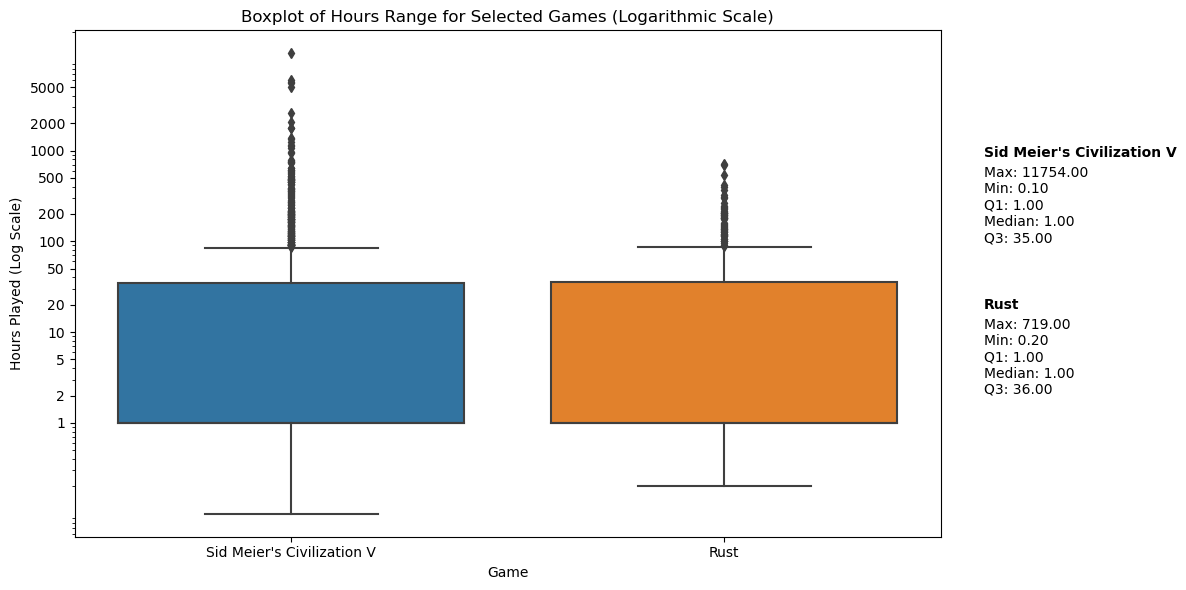

In [41]:
selected_games = ["Rust", "Sid Meier's Civilization V"]
filtered_data = df[df['Game'].isin(selected_games)]

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.boxplot(x=filtered_data['Game'], y=filtered_data['Hours_Played'], ax=ax1)
ax1.set_yscale("log")

yticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks)

ax2 = ax1.twinx()
ax2.axis('off')  

info_texts = []
y_position = 0.45  
for game in selected_games:
    game_data = filtered_data[filtered_data['Game'] == game]['Hours_Played']
    
    
    min_val = game_data.min()
    max_val = game_data.max()
    q1 = game_data.quantile(0.25)
    median = game_data.median()
    q3 = game_data.quantile(0.75)
    
    
    ax2.text(1.05, y_position, game, weight='bold', transform=ax2.transAxes)
    y_position -= 0.2  
    info = f"Max: {max_val:.2f}\nMin: {min_val:.2f}\nQ1: {q1:.2f}\nMedian: {median:.2f}\nQ3: {q3:.2f}\n"
    ax2.text(1.05, y_position, info, transform=ax2.transAxes)
    y_position = .75  

plt.title('Boxplot of Hours Range for Selected Games (Logarithmic Scale)')
ax1.set_ylabel('Hours Played (Log Scale)')
ax1.set_xlabel('Game')
plt.tight_layout()  
plt.show()

## Distribution of Players Across All Games


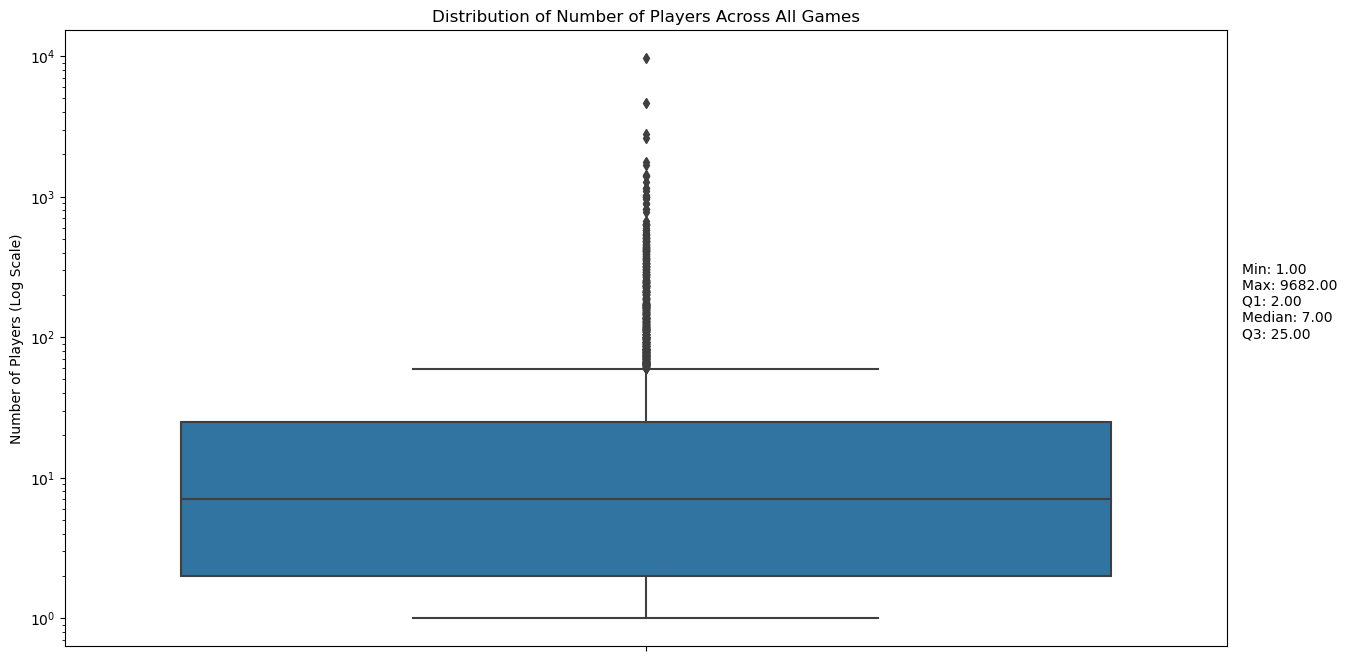

In [42]:
number_of_players = df.groupby('Game').size().reset_index(name='Number_of_Players')

plt.figure(figsize=(15, 8))
ax = sns.boxplot(y=number_of_players['Number_of_Players'])

plt.yscale('log')

plt.title('Distribution of Number of Players Across All Games')
plt.ylabel('Number of Players (Log Scale)')

min_val = number_of_players['Number_of_Players'].min()
max_val = number_of_players['Number_of_Players'].max()
q1 = np.percentile(number_of_players['Number_of_Players'], 25)
median = np.median(number_of_players['Number_of_Players'])
q3 = np.percentile(number_of_players['Number_of_Players'], 75)

stats_str = ("\n\nMin: {:.2f}\nMax: {:.2f}\nQ1: {:.2f}\nMedian: {:.2f}\nQ3: {:.2f}".format(min_val, max_val, q1, median, q3))
plt.annotate(stats_str, xy=(1.0125, 0.50), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="none"))

plt.show()

# Bivariate Analysis

## Correlation and One-Way ANOVA

From our correlation analysis, we ontained a correlation coefficient of 0.502, which means that there's a moderate positive linear relationship between the number of games and the hours played.

##### As the number of games a user plays goes up, we see that the total time they spend playing also tends to go up.

From our one-way ANOVA results, we obtained a p-value of 3.859381363817813e-256, which is very close to zero. Hence, we can be very confident that the average playtime is different between at least some of the games. 

##### The average playtime does indeed vary between different games.


In [43]:
user_total_hours = df.groupby('User_ID')['Hours_Played'].sum()

user_num_games = df.groupby('User_ID')['Game'].nunique()

correlation = user_total_hours.corr(user_num_games)
print(f"Correlation between number of games played and total hours played: {correlation}")

games = df['Game'].unique()
game_groups = [df['Hours_Played'][df['Game'] == game] for game in games]

anova_results = stats.f_oneway(*game_groups)

print(f"ANOVA results: {anova_results}")

Correlation between number of games played and total hours played: 0.5021569204218044
ANOVA results: F_onewayResult(statistic=1.8517606827202544, pvalue=3.859381363817813e-256)


In [44]:
crosstab = pd.crosstab(index=df['User_ID'], columns=df['Game'], values=df['Hours_Played'], aggfunc='sum')

crosstab = crosstab.dropna(how='all')

print(crosstab)

Game       007 Legends  0RBITALIS  \
User_ID                             
5250               NaN        NaN   
76767              NaN        NaN   
86540              NaN        NaN   
103360             NaN        NaN   
144736             NaN        NaN   
...                ...        ...   
309554670          NaN        NaN   
309626088          NaN        NaN   
309812026          NaN        NaN   
309824202          NaN        NaN   
309903146          NaN        NaN   

Game       1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)  \
User_ID                                                                 
5250                                                     NaN            
76767                                                    NaN            
86540                                                    NaN            
103360                                                   NaN            
144736                                                   NaN            
...    

## K-Means Clustering

Next we'll use K-Means clustering and Tukey's HSD test to segment users based on their hours of gameplay, allowing us to better understand user behavior.

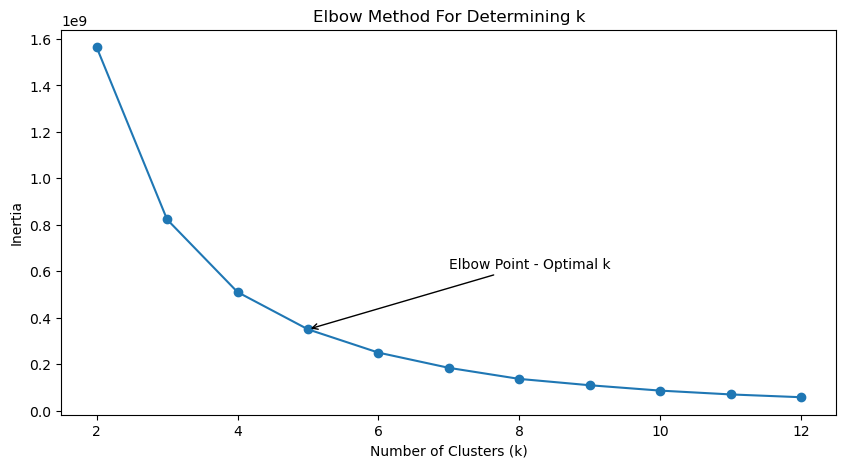

            count         mean          std     min      25%     50%     75%  \
Cluster                                                                        
0        196124.0     5.667337    16.823118     0.1     1.00     1.0     1.0   
1           208.0  2407.129808   584.216571  1727.0  1916.50  2273.5  2702.5   
2           781.0  1041.574904   270.284344   686.0   814.00   993.0  1230.0   
3            38.0  5518.736842  1755.699886  4021.0  4500.75  4824.5  5944.0   
4          2849.0   329.768691   135.989399   168.0   216.00   289.0   422.0   

             max  
Cluster           
0          167.0  
1         3940.0  
2         1719.0  
3        11754.0  
4          682.0  


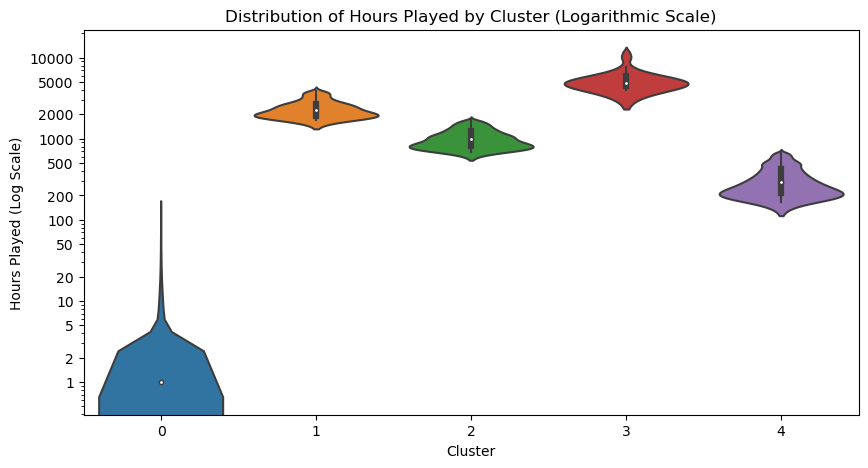

In [45]:
from sklearn.cluster import KMeans
from statsmodels.stats.multicomp import pairwise_tukeyhsd

inertias = []
k_values = list(range(2, 13))

for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=10, random_state=42).fit(df[['Hours_Played']])
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(k_values, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Determining k')
plt.annotate('Elbow Point - Optimal k', xy=(5, inertias[3]), xytext=(7, inertias[2]*1.2),
            arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.show()

chosen_k = 5  
kmeans = KMeans(n_clusters=chosen_k, max_iter=25, random_state=42).fit(df[['Hours_Played']])
df['Cluster'] = kmeans.labels_

cluster_summary = df.groupby('Cluster')['Hours_Played'].describe()
print(cluster_summary)

plt.figure(figsize=(10,5))
sns.violinplot(x='Cluster', y='Hours_Played', data=df, scale="width")
plt.yscale("log")

yticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
plt.yticks(yticks, yticks)

plt.title('Distribution of Hours Played by Cluster (Logarithmic Scale)')
plt.ylabel('Hours Played (Log Scale)')
plt.xlabel('Cluster')
plt.show()

## Tukey's HSD test

From the distribution of hours graph alone, it looks like the mean differences in gameplay hours would be different. We can do a Tukey's HSD test to confirm this. 

In [46]:
tukey_results = pairwise_tukeyhsd(df['Hours_Played'], df['Cluster'])

print(tukey_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj   lower      upper    reject
-----------------------------------------------------------
     0      1  2401.4625   0.0  2393.5476  2409.3773   True
     0      2  1035.9076   0.0   1031.817  1039.9981   True
     0      3  5513.0695   0.0    5494.56  5531.5791   True
     0      4   324.1014   0.0   321.9484   326.2543   True
     1      2 -1365.5549   0.0 -1374.4569 -1356.6529   True
     1      3   3111.607   0.0  3091.4795  3131.7345   True
     1      4 -2077.3611   0.0 -2085.5555 -2069.1668   True
     2      3  4477.1619   0.0  4458.2093  4496.1146   True
     2      4  -711.8062   0.0  -716.4144  -707.1981   True
     3      4 -5188.9682   0.0 -5207.5989 -5170.3374   True
-----------------------------------------------------------


The test reveals that the mean differences in gameplay hours between all the clusters are indeed statistically significant. This confirms that the clusters represent distinct segments of users in terms of their gameplay hours.

## Interpreting the clusters 

Now, let's rank and visualize the clusters by size and average gameplay. 

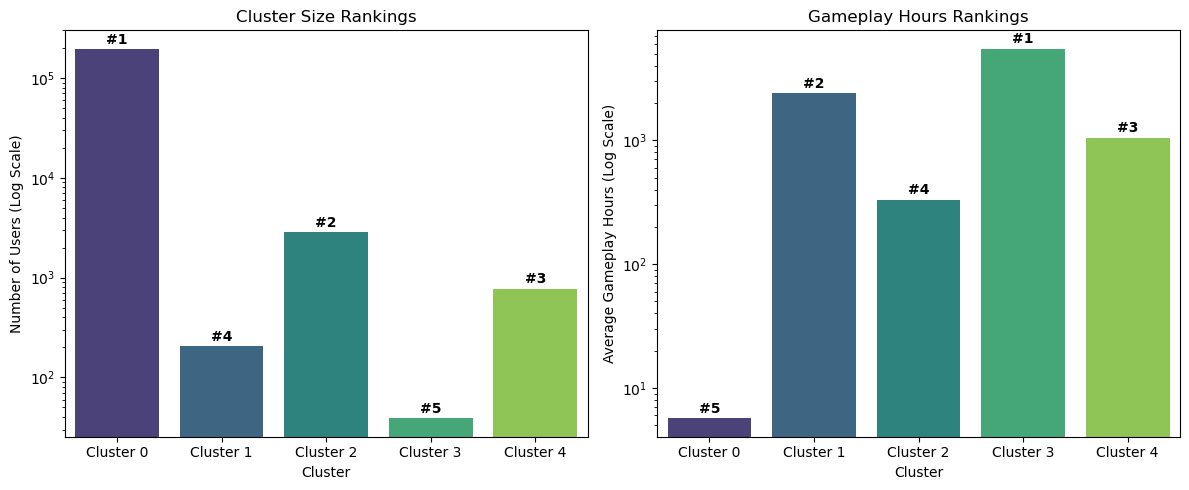

In [47]:
clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
sizes = [196141.0, 207.0, 2836.0, 39.0, 777.0]
size_rankings = ["#1", "#4", "#2", "#5", "#3"]

hours_means = [5.681407, 2399.724638, 331.241537, 5478.256410, 1043.402831]
hours_rankings = ["#5", "#2", "#4", "#1", "#3"]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=clusters, y=sizes, palette='viridis')
plt.yscale('log')
plt.title('Cluster Size Rankings')
plt.ylabel('Number of Users (Log Scale)')
plt.xlabel('Cluster')
for i, v in enumerate(size_rankings):
    plt.text(i, sizes[i] * 1.05, v, ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
sns.barplot(x=clusters, y=hours_means, palette='viridis')
plt.yscale('log')
plt.title('Gameplay Hours Rankings')
plt.ylabel('Average Gameplay Hours (Log Scale)')
plt.xlabel('Cluster')
for i, v in enumerate(hours_rankings):
    plt.text(i, hours_means[i] * 1.05, v, ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Interpreting the clusters, we have

##### Cluster 0 (Ranks: Size: #1, Gameplay: #5):
This is the largest cluster, comprising users who played games for an average of approximately 5.68 hours. The majority played for up to 1 hour.
##### Cluster 1  (Ranks: Size: #4, Gameplay: #2):
These users have an average gameplay time of around 2399.72 hours. 

##### Cluster 2 (Ranks: Size: #2, Gameplay: #4):
Gamers in this cluster played for an average of 331.24 hours. 

##### Cluster 3 (Ranks: Size: #5, Gameplay: #1):
This is the smallest cluster, with users playing games for an astounding average of 5478.25 hours.

##### Cluster 4 (Ranks: Size: #3, Gameplay: #3):
These users played games for an average of 1043.40 hours.


# Predictive Modeling

## Decision Tree

Using a decision tree, we can predict if someone plays more than a certain number of hours based on dummy variables for each game. This quantity of hours will be determined by the 75th percentile of hours played for each cluster. 

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

for cluster_id in df['Cluster'].unique():
    df_cluster = df[df['Cluster'] == cluster_id].copy()
    
    threshold_hours_cluster = df_cluster['Hours_Played'].quantile(0.75)
    df_cluster['Played_More_Than_Cluster_Threshold'] = (df_cluster['Hours_Played'] > threshold_hours_cluster).astype(int)
    
    X_cluster = pd.get_dummies(df_cluster.drop(['Hours_Played', 'Played_More_Than_Cluster_Threshold', 'Cluster'], axis=1))
    y_cluster = df_cluster['Played_More_Than_Cluster_Threshold']
    
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
    
    clf_cluster = DecisionTreeClassifier()
    clf_cluster.fit(X_train_cluster, y_train_cluster)
    y_pred_cluster = clf_cluster.predict(X_test_cluster)
    
    print(f"Model for Cluster {cluster_id}:")
    print(classification_report(y_test_cluster, y_pred_cluster))



Model for Cluster 0:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     29413
           1       0.76      0.85      0.80      9812

    accuracy                           0.89     39225
   macro avg       0.85      0.88      0.87     39225
weighted avg       0.90      0.89      0.90     39225

Model for Cluster 4:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       456
           1       0.20      0.26      0.23       114

    accuracy                           0.65       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.68      0.65      0.66       570

Model for Cluster 1:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.22      0.20      0.21        10

    accuracy                           0.64        42
   macro avg       0.49      0.49      0.49        42
weighted av

## Interpreting the Results 

We can rank how well the model works on each cluster by ranking them based on their f1-score. 

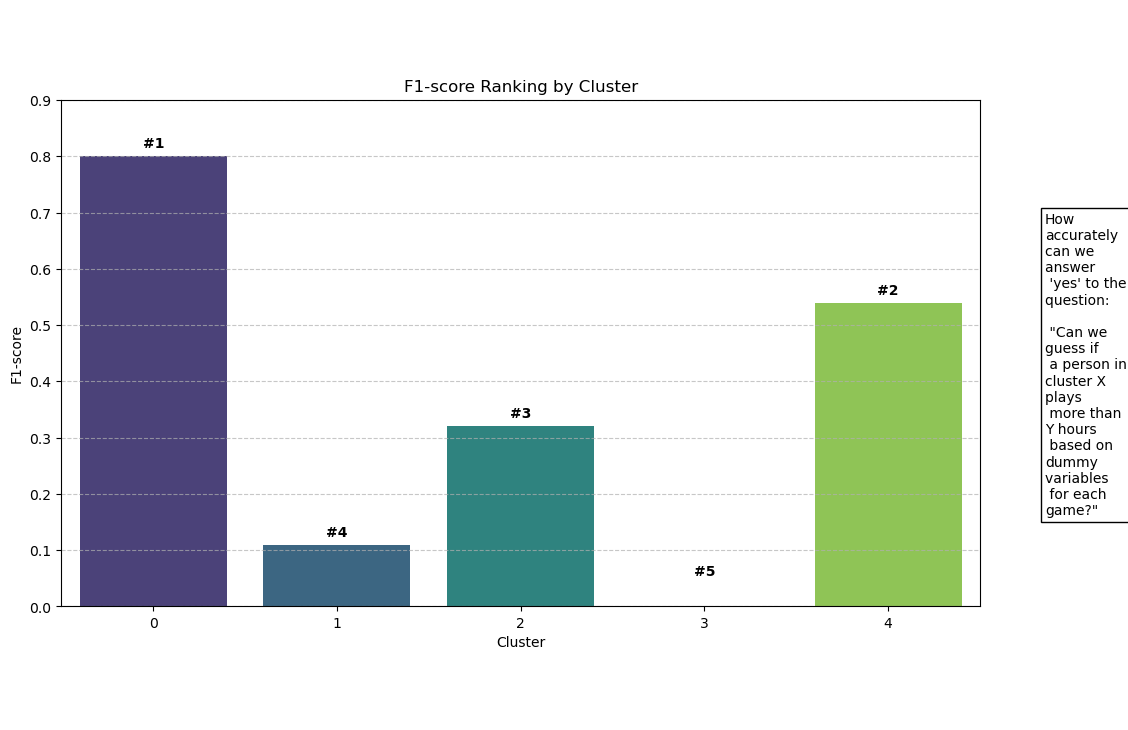

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

decision_tree_data = {
    'Cluster': [0, 4, 2, 1, 3],
    'F1_score': [0.80, 0.54, 0.32, 0.11, 0.00]
}

decision_tree_df = pd.DataFrame(decision_tree_data)

df_sorted = decision_tree_df.sort_values(by='F1_score', ascending=False)
df_sorted['Rank'] = range(1, len(decision_tree_df) + 1)
ranking = df_sorted.set_index('Cluster')['Rank'].to_dict()

fig, ax = plt.subplots(figsize=(10, 6))
bars = sns.barplot(data=decision_tree_df, x='Cluster', y='F1_score', palette='viridis', ax=ax)

for bar in bars.patches:
    y_value = bar.get_height()
    cluster = int(bar.get_x() + bar.get_width() / 2)
    rank = ranking[cluster]
    offset = 0.01 if y_value > 0.1 else 0.05
    bars.text(bar.get_x() + bar.get_width() / 2, y_value + offset, '#' + str(rank), 
              ha='center', va='bottom', color='black', fontweight='bold')

ax.set_title('F1-score Ranking by Cluster')
ax.set_ylim(0, 0.9)
ax.set_xlabel('Cluster')
ax.set_ylabel('F1-score')
ax.grid(axis='y', linestyle='--', alpha=0.7)

message = "How accurately can we answer \n 'yes' to the question: \n \n \"Can we guess if \n a person in cluster X plays \n more than Y hours \n based on dummy variables \n for each game?\""
fig.text(1.05, 0.5, message, fontsize=10, wrap=True, bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"), va='center')

plt.tight_layout()
plt.show()


#### Cluster 0 (Rank: #1):

For players in cluster 0, we can most accurately answer 'yes' to the question "Can we guess if someone plays more than Y hours based on dummy variables for each game?"

#### Cluster 4  (Rank: #2):

For players in cluster 4, we can accurately answer 'yes' to the question "Can we guess if someone plays more than Y hours based on dummy variables for each game?", but not nearly as much as for players in cluster 0.

#### Cluster 2 (Rank: #3):

For players in cluster 2, we can less accurately answer 'yes' to the question "Can we guess if someone plays more than Y hours based on dummy variables for each game?" in comparison to cluster 4 or 0.

#### Cluster 1 (Rank: #4):

For players in cluster 1, we can only somewhat accurately answer 'yes' to the question "Can we guess if someone plays more than Y hours based on dummy variables for each game?"

#### Cluster 3 (Rank: #5):

For players in cluster 3, we cannot accurately answer 'yes' to the question "Can we guess if someone plays more than Y hours based on dummy variables for each game?"


## Interesting Thought

Cluster 0, while being the largest in size, has the lowest average gameplay duration. In contrast, Cluster 4 is notable for ranking third in both size and average gameplay duration.

Our decision tree analysis suggests that the gaming preferences in Clusters 0 and 4 are significantly shaped by specific games dominant within each cluster. This raises the question: Could we transition users from Cluster 0 to Cluster 4 by recommending or offering incentives for the games most popular within Cluster 4? If so, this could signficantly increase user engagement.

Let's take a look at the top 10 games for both clusters. 

In [54]:
query_cluster0 = """
    SELECT 
        Cluster, 
        Game, 
        SUM(Hours_Played) as Total_Hours_Played 
    FROM 
        gaming_data 
    WHERE 
        Cluster = 0
    GROUP BY 
        Game
    ORDER BY 
        Total_Hours_Played DESC
    LIMIT 
        10
"""

query_cluster4 = """
    SELECT 
        Cluster, 
        Game, 
        SUM(Hours_Played) as Total_Hours_Played 
    FROM 
        gaming_data 
    WHERE 
        Cluster = 4
    GROUP BY 
        Game
    ORDER BY 
        Total_Hours_Played DESC
    LIMIT 
        10
"""

result_cluster0 = pd.read_sql(query_cluster0, conn)
result_cluster4 = pd.read_sql(query_cluster4, conn)

from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str))

display_side_by_side(result_cluster0, result_cluster4)



,Cluster,Game,Total_Hours_Played
0,0,Dota 2,67415.6
1,0,Team Fortress 2,37533.3
2,0,Counter-Strike Global Offensive,35117.6
3,0,The Elder Scrolls V Skyrim,24736.3
4,0,Sid Meier's Civilization V,18085.3
5,0,Left 4 Dead 2,17547.7
6,0,Garry's Mod,17105.3
7,0,Counter-Strike Source,15714.5
8,0,Terraria,14306.8
9,0,Unturned,14015.4


As you can see, we have "Call of Duty Modern Warfare 2 - Multiplayer", "Counter-Strike", and "Football Manager 2012" present in the top 10 for cluster 4, but not in the top 10 for cluster 0.

Recommending or incentivizing gameplay for games like those to players in cluster 0 could boost overall user engagement by transitioning them into a cluster with a heavier average hours that are also heavily influenced by the games they play like cluster 4. 

# Visualization/Reporting

## Gameplay Analysis Dashboard

### Section 1 - General Game Insights:

In the analysis, I visualized the range of the hours played with boxplots of two games with a large range of hours played: Rust and Sid Meier's Civilization V. The latter has the largest range of hours played in the dataset. I also visualized the distribution of players across all games  with a boxplot. 

Use the two buttoms below to switch between the visualizations. 

In [51]:
from IPython.core.display import display, HTML
import json

# List of your image paths
image_paths = [
    "images/Boxplot of Hours Range.png",
    "images/Distribution of Number of Players.png"
]

# Create the HTML and JavaScript code
slideshow_html = """
<div style="display: flex; flex-direction: column; align-items: center; justify-content: center;">
    <div style="position: relative; display: flex; align-items: center; justify-content: center; width: 900px; height: 600px; overflow: hidden;">
      <img id="slideshow-img4" src="{0}" style="max-width: 100%; max-height: 100%;"/>
    </div>
    <div style="text-align: center; margin-top: 10px; display: flex; justify-content: center; width: 900px;">
      <button id="left-arrow4" style="margin-right: 2%;" onclick="changeImage4(-1)">&#10094;</button>
      <button id="right-arrow4" style="margin-left: 2%;" onclick="changeImage4(1)">&#10095;</button>
    </div>
</div>

<script>
    var images4 = {1};
    var imageIndex4 = 0;
    
    function changeImage4(step) {{
        imageIndex4 += step;
        imageIndex4 = (imageIndex4 + images4.length) % images4.length;
        document.getElementById("slideshow-img4").src = images4[imageIndex4];
    }}
</script>
""".format(image_paths[0], json.dumps(image_paths))

display(HTML(slideshow_html))



### Section 2 - Clustering Insights:



I then did K-Means clustering and Tukey's HSD test to segment users based on their hours of gameplay, allowing me to better understand user behavior. The Tukey's HSD test confirmed that the mean differences in gameplay hours between all the clusters are indeed statistically significant.

I then did further analysis on the size and average gameplay hours for each cluster. Use the buttons below to flip through the visualizations of my findings. 

In [52]:
from IPython.core.display import display, HTML
import json

# List of your image paths
image_paths_clustering = [
    "Clustering Insights Pictures/Clustering Distribution.png",
    "Clustering Insights Pictures/Cluster Size Rankings.png",
    "Clustering Insights Pictures/Gameplay_Hours_Rankings.png"
]

# Create the HTML and JavaScript code
slideshow_html_clustering = """
<div style="display: flex; flex-direction: column; align-items: center; justify-content: center;">
    <div style="position: relative; display: flex; align-items: center; justify-content: center; width: 900px; height: 600px; overflow: hidden;">
      <img id="slideshow-img2" src="{0}" style="max-width: 100%; max-height: 100%;"/> 
    </div>
    <div style="text-align: center; margin-top: 10px; display: flex; justify-content: center; width: 900px;">
      <button id="left-arrow2" style="margin-right: 2%;" onclick="changeImage2(-1)">&#10094;</button>
      <button id="right-arrow2" style="margin-left: 2%;" onclick="changeImage2(1)">&#10095;</button>
    </div>
</div>

<script>
    var images2 = {1};
    var imageIndex2 = 0;
    
    function changeImage2(step) {{
        imageIndex2 += step;
        imageIndex2 = (imageIndex2 + images2.length) % images2.length;
        document.getElementById("slideshow-img2").src = images2[imageIndex2];
    }}
</script>
""".format(image_paths_clustering[0], json.dumps(image_paths_clustering))

display(HTML(slideshow_html_clustering))



### Section 3 - Model Performance by Cluster:

I then used a decision tree to answer the following question for each cluster: "Can we guess if someone plays more than Y hours based on dummy variables for each game?"

For each cluster, I let the 75th percentile be the "Y" hours. I then determined how accurately we could say 'yes' to this question by each cluster's F1-score, and ranked each cluster accordingly. 

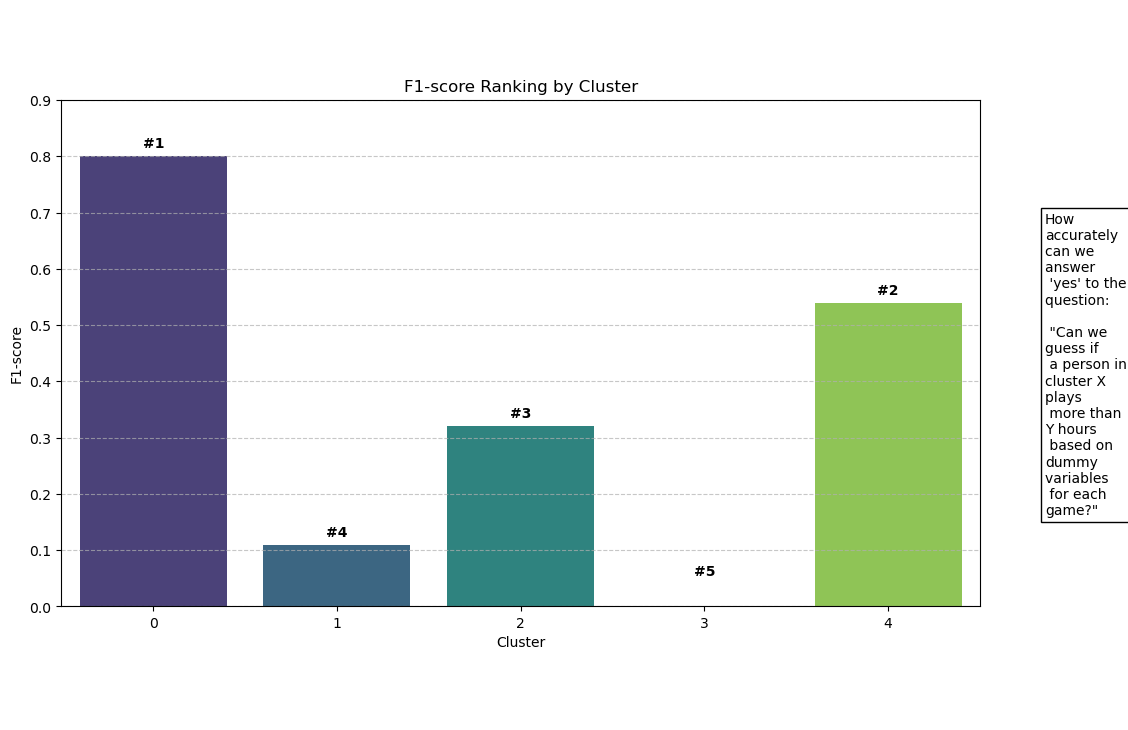

# Written Report 

## Objectives of Analysis
- Understand user engagement in terms of gameplay hours.
- Cluster users based on their average playtime.
- Predict if an individual will play beyond a certain threshold using dummy variables for each game.

## Descriptive Statistics
- **Total Users:** Approximately 12,393
- **Total Gameplay Hours:** ~3.5 million hours
- **Games per User:** Approximately 5 games/user
- **Average Gameplay:** 278 hours/user

## Bivariate Analysis
- A moderate positive correlation exists between the number of games a user possesses and their playtime, given by \( r = .502 \).
- The one-way ANOVA test confirmed that average playtime differs among games with a p-value much less than 0.01 (indicating high significance).

## K-means Clustering
- Users are grouped into 5 unique clusters based on their gameplay duration.
- The clusters are ranked by their user count and total gameplay.
- A Tukey's HSD test verifies statistically significant differences in gameplay hours across the clusters.

## Decision Tree Predictions
- Addressed the query: "Can we estimate if an individual in cluster X plays more than Y hours based on game-specific dummy variables?"
    - 'Y hours' corresponds to the 75th percentile of playtime within each cluster.
- The ability to affirmatively answer the above question varies for each cluster and is measured using the F1-score.

## Conclusions
- **User Engagement Varies:** 
    - Not every user interacts equally with games. While many lean towards casual gaming, a smaller segment displays deep commitment, accumulating thousands of gameplay hours.
    
- **Predictability of Playtime:** 
    - Game variables most effectively predict gameplay hours for Cluster 0 and Cluster 4. Usually as clusters display increased gameplay hours, the predictability lessens.

- **Strategic Implications:** 
    - Recognizing these user groups enables the crafting of custom marketing and engagement tactics. E.g., high engagement clusters (such as Cluster 3) may be primed for premium or extended content offerings. In contrast, the larger Cluster 0, typified by casual gamers, might resonate more with new game promotions or introductions.


# Actionable Recommendations

## 1.) Target Premium and Extended Content to Cluster 3 and Cluster 1 Players.

1. **Objective:** 
   - Cater premium and extended content to high-engagement clusters, namely Cluster 3 and Cluster 1, to extend their engagement. 
  
2. **Implementation:**

   - **Content Personalization:** Develop or collaborate with game developers to offer exclusive content such as in-game items, extended gameplay modes, or special story arcs tailored for these clusters.
   - **Promotion and Awareness:** Inform players in Clusters 3 and 1 about the exclusive content through in-platform notifications, emails, or personalized offers.
     
3. **Rationale:**
   - Players in Clusters 3 and 1, due to their higher engagement, are more likely to invest further in games they enjoy. Offering them premium or extended content can not only increase revenue but also improve their overall gaming experience and satisfaction.
   
4. **Potential Outcomes:**
   - Incremental revenue from the sale of premium content to these high-engagement clusters.
   - Enhanced in-game experiences leading to positive word-of-mouth and potential user growth.


## 2.) Strategically Leverage the Recommendation Engine to Drive Engagement: Targeting Cluster 0 and 2 Players with Top Performing Games from Cluster 4

1. **Objective:** 
   - Increase user engagement levels in clusters with lower average gameplay hours, particularly Cluster 0 and Cluster 2.
2. **Implementation:**

   - **Data-Driven Insights:** Utilize the game preference data from Cluster 4. Identify the games that are popular within this cluster and are less played or unplayed by users in Cluster 0 and Cluster 2.
   - **Recommendation System Enhancement:** Modify the recommendation engine to prioritize and suggest these identified games to users in Cluster 0 and Cluster 2.
   - **Incentive Programs:** Offer discounts, achievement badges, or limited-time game access passes to entice Cluster 0 and Cluster 2 players to try out and play these recommended games.
     
3. **Rationale:**
   - Cluster 4 exhibits higher gameplay averages influenced largely by specific games popular within that cluster. Introducing these games to players in clusters with lower average gameplay hours might potentially boost their engagement levels. 

4. **Potential Outcomes:**
   - An increase in average gameplay hours for Cluster 0 and Cluster 2 users.
   - Improved game sales or in-game purchases stemming from the newly recommended games.
   - Higher user satisfaction and retention rates due to a more personalized game recommendation experience.

# Conclusion

This analysis dives deep into different clusters of gamers, aiming to understand patterns of game play and how specific games influence gameplay duration. Given the absence of timeframe data, our insights are based on aggregated gameplay durations without time context. Even without timeframe date, however, we can still devise strategies to potentially enhance user engagement and overall platform revenue.

## Findings:

### Interesting Observations:

- **Cluster 0**, despite being the largest, has the lowest average gameplay duration.
- **Cluster 4**, is notable for ranking third in both size and average gameplay duration.
- Decision tree analysis suggests that game preferences in Clusters 0 and 4 are significantly influenced by specific dominant games.

#### Top Games for Each Cluster:

Cluster 0 is dominated by games such as Dota 2, Team Fortress 2, and Counter-Strike Global Offensive among others. Meanwhile, Cluster 4 has unique top games like "Call of Duty Modern Warfare 2 - Multiplayer", "Counter-Strike", and "Football Manager 2012" which are not present in Cluster 0's top 10.

Given this insight, there's an opportunity: Transitioning users from Cluster 0 to Cluster 4 by recommending or offering incentives for the games popular within Cluster 4 could significantly increase user engagement.

## Actionable Recommendations:

### 1.) Target Premium and Extended Content to Cluster 3 and Cluster 1 Players.

- **Objective:** Cater premium and extended content to high-engagement clusters, specifically Cluster 3 and Cluster 1.
  
- **Implementation:**
  - **Content Personalization:** Offer exclusive in-game items, extended gameplay modes, or special story arcs tailored for these clusters.
  - **Promotion and Awareness:** Use in-platform notifications or personalized offers to make players aware of exclusive content.
     
- **Rationale:** These clusters, due to their higher engagement, are more likely to invest in games they love. Offering premium content can increase revenue and improve their gaming satisfaction.
  
- **Potential Outcomes:** Increased revenue from premium content sales and a better overall gaming experience which could lead to positive word-of-mouth.

## Limitations of the Analysis:

1. **Model Overfitting:** The decision tree model might overfit the data that we were given, making it less effective with new data.
2. **Static Thresholds:** The fixed threshold for hours played might not be universally representative.
3. **Cluster Dependency:** Migrating users from one cluster to another may not guarantee increased gameplay duration.
4. **Lack of Temporal Data:** Without timeframe data, our analysis lacks the ability to discern temporal trends or seasonality in gameplay.
5. **Lack of Contextual Data:** Other potential factors influencing gameplay, like user demographics or device types, weren't considered.

## Future Analysis and Strategies:

1. **Integrate Timeframe Data:** If available, incorporate timeframe data for a more detailed temporal analysis.
2. **Use Advanced Machine Learning Models:** Implement Random Forests or Gradient Boosted Trees for better prediction accuracy.
3. **Adopt Dynamic Thresholds:** Implement rolling percentiles or adaptive binning for gameplay duration.
   > In the decision tree analysis, I used the 75th percentile of gameplay duration within each cluster to create a binary classification of whether a player played more than the cluster's threshold. This was instead of using adaptive binning. Additionally, I lacked timeframe data, which prevented the utilization of rolling percentiles.
4. **A/B Testing:** Test the efficacy of game recommendations on small segments before large-scale implementation.
5. **Sentiment Analysis:** Incorporate user reviews to get a qualitative understanding of gameplay experiences.

## Conclusion:

The gaming platform has a rich tapestry of players with different preferences and behaviors. By understanding these dynamics, even without temporal data, and tailoring strategies around them, we can work towards enhancing user engagement and driving platform growth.


In [1]:
pip install voila


  Obtaining dependency information for voila from https://files.pythonhosted.org/packages/d5/93/7c9a280438b54c107875551a5a159d4bc0f66d94083040ca780df104d56d/voila-0.4.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/124.7 kB ? eta -:--:--
     ---------------------------- ---------- 92.2/124.7 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 124.7/124.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 3.3 MB/s eta 0:00:01
   ----- ---------------------------------- 0.2/1.4 MB 3.0 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.4 MB 4.2 MB/s eta 0:00:01
   ------------------------- -------------- 0.9/1.4 MB 6.1 MB/s eta 0:00:01
   ----------------------------------- ---- 1.2/1.4 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.3 MB/s eta 0:00:00
